## <center><b>Western University</b></center>
## <center><b>Faculty of Engineering</b></center>
## <center><b>Department of Electrical and Computer Engineering</b></center>

# <center><b>AISE 3350A FW24: Cyber-Physical Systems Theory</b></center>
# <center><b>Group 13 - Project</b></center>


Students:
- Jahangir (Janik) Abdullayev (251283871)
- Richard Augustine (251275608)
- Matthew Linders (251296414)
- Xander Chin  (251314531)
- Joseph Kim (251283383)


Segmentation of the M&Ms

In [28]:
import cv2
import matplotlib.pyplot as plt
from fastsam import FastSAM, FastSAMPrompt

%matplotlib inline

In [29]:
# gui here
# upload pic and store img to raw_image

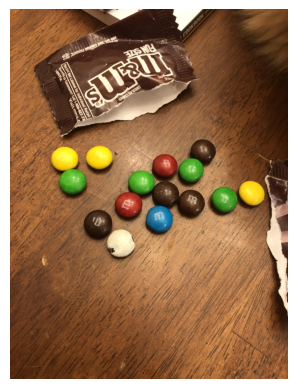

In [30]:
img_url = "m&m_pic_stolen_from_reddit.jpg"
raw_image = cv2.cvtColor(cv2.imread(img_url), cv2.COLOR_BGR2RGB) 
plt.imshow(raw_image)
plt.axis("off")
plt.show()

input_points = [[[450, 600]]]

c:\Users\janik\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\nn\tasks.py:518: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file, m

24


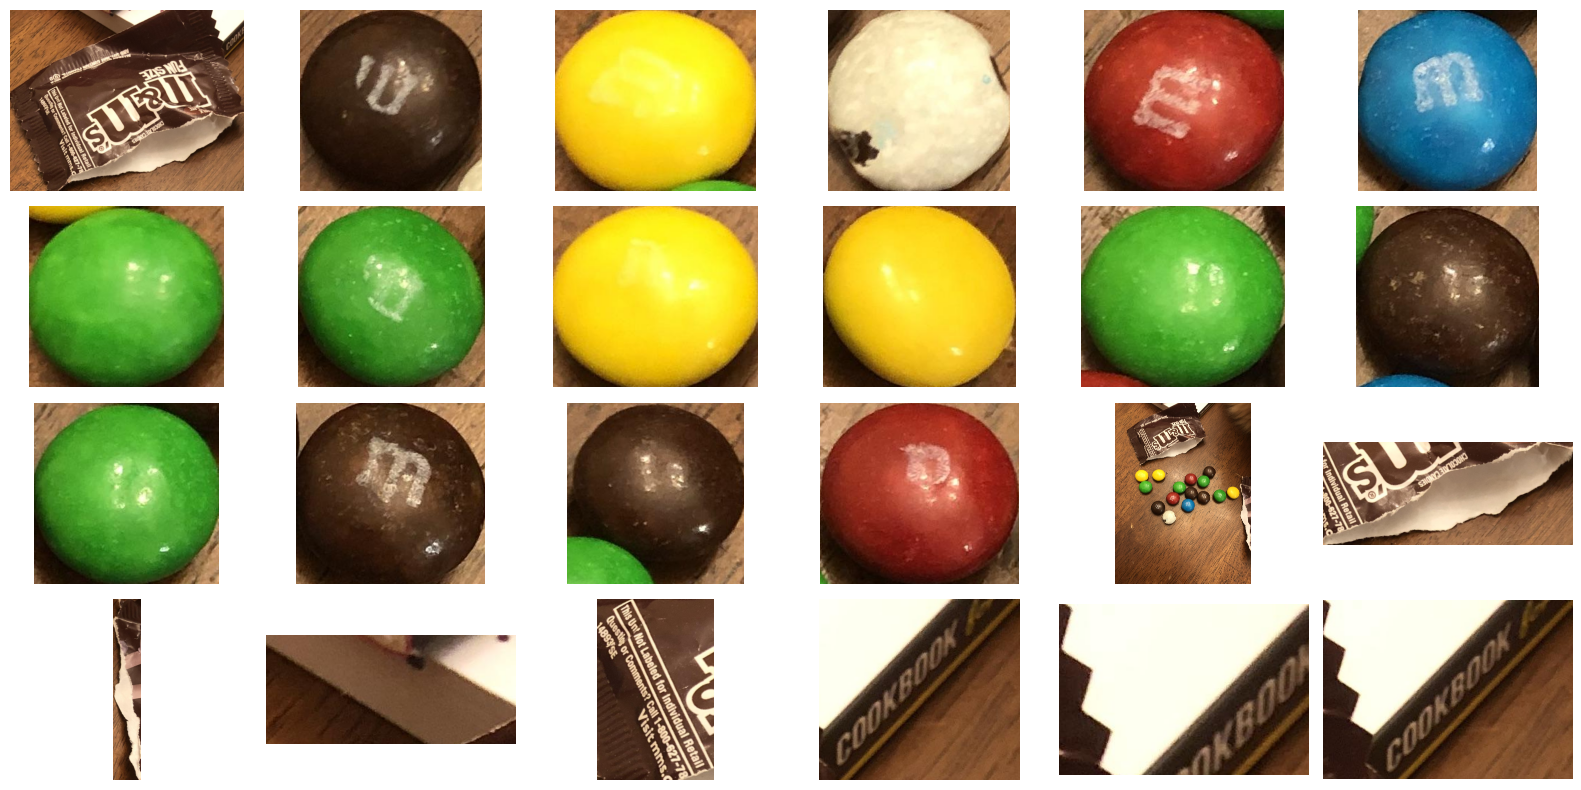

In [31]:

img_dict = {
    "vector": [],
    "boundary": [],
    "similarity": [],
}

modelSAM = FastSAM("FastSAM-x.pt")

everything_results = modelSAM(
    img_url,
    device="cpu",
    retina_masks=True,
    imgsz=384,
    conf=0.3,
    iou=0.9,
)
prompt_process = FastSAMPrompt(img_url, everything_results, device="cpu")

# everything prompt
prompt_process.everything_prompt()

num_of_masks = len(everything_results[0])
print(num_of_masks)

# display images with matplotlib
fig, axes = plt.subplots(nrows=int(np.ceil(num_of_masks / 6)), ncols=6, figsize=(16, 8))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for index, r in enumerate(everything_results[0]):
    maskCoords = (r.masks.xy)[0]

    xy_array = np.array(maskCoords)
    contour = xy_array.reshape((-1, 1, 2)).astype(np.int32)

    x, y, w, h = cv2.boundingRect(contour)
    img_dict["boundary"].append((x, y, w, h))

    ax = axes[index]
    result_image = raw_image[y : y + h, x : x + w]
    ax.axis("off")
    ax.imshow(result_image)

plt.tight_layout()
plt.show()


Your project report should contain these sections:

- **Introduction**: Detail the motivation and background context explaining why this counting topic was chosen
- **Methods**: Explain how you modified the sample code. If using ML, describe which model was chosen (and why), and how it was integrated into the existing code
- **Results**: Write as a user manual explaining how to use your code. Include:
  * Sample test images
  * A set of documented tests
  * Results in tables and graphs
    * Consider using [numpy](https://numpy.org/) for any mathematical calculation including statistics
    * Consider using [matplotlib](https://matplotlib.org/) for graphs and plots.
    * The combination of [numpy](https://numpy.org/) and [matplotlib](https://matplotlib.org/) simulates the Matlab environment and the syntax are almost identical!
- **Discussion**: Explain:
  * Why you chose your approach
  * What was needed to make it work
  * If issues arose, document the reasons (**It is acceptable if your program doesn't work perfectly** as long as you investigate why)
  * Potential societal/economic implications and impact
- **Conclusion**: Detail what you learned
- **Bibliography**: Provide a list of references relevant to your report. For example, if you use a publicly available ML model, provide a citation/reference to the original paper and the URL where you downloaded the model.

installing:

pip install transformers opencv-python matplotlib
must download this https://drive.google.com/file/d/1m1sjY4ihXBU1fZXdQ-Xdj-mDltW-2Rqv/view

Introduction:
What's the problem and why do we care.

Method:
We are using the Segment Anything Model. We chose this because of the low barrier to entry, and it's inherent effectiveness with 